In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import itertools
import warnings
import torch
import pandas as pd
import seaborn as sns

In [2]:
class ComputationalGraph():
    """Represents a computational graph."""

    def __init__(self):
        # The graph in the form of an adjacency list. 
        # Each key in the dictionary is a Node ID and the corresponding value 
        # is the list of ID's of edges that originate from that Node.
        self.forwardAdj = {}

        # Dictionary of backward edge connections.
        self.backwardAdj = {}
        
        # The set of ID's of edges that belong to the computational graph.
        self.edges = set()
    
    
    def add_node(self, nodeId):
        """Add a node to the graph."""
        try:
            _ = Node.get(nodeId)
        except KeyError:
            raise
       
        if nodeId in self.forwardAdj:
            warnings.warn("Warning..... Atempting to add node that already exists in Computational Graph. Ignored.")
            return
        
        self.forwardAdj[nodeId] = []
        self.backwardAdj[nodeId] = []

    
    def add_edge(self, edgeId):
        """Add an edge to the graph."""
        try:
            edge = Edge.get(edgeId)
        except KeyError:
            raise

        if edgeId in self.edges:
            warnings.warn("Warning..... Atempting to add edge that already exists in Computational Graph. Ignored.")
            return
        
        if edge.nodeFromId not in self.forwardAdj or edge.nodeToId not in self.forwardAdj:
            raise ValueError('Both nodes of the edge must belong to the Computational Graph')

        self.edges.add(edgeId)
        self.forwardAdj[edge.nodeFromId].append(edgeId)
        self.backwardAdj[edge.nodeToId].append(edgeId)

    def getConnectedComponent(self, nodeId):
        """Return a connected component containing node with given Id.
        Assumes undirected graph.
        """
        visited = {}
        connectedComponent = []
        
        def dfs(nodeId, graph):
            """Perform a depth-first-traversal from the given node, 
            adding each node id on the path to the connectedCOmponent list.
            """
            visited[nodeId] = True
            connectedComponent.append(nodeId)
            for edgeId in graph.forwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                neighbourId = edge.nodeToId
                if neighbourId not in visited:
                    dfs(neighbourId, graph)
            for edgeId in graph.backwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                neighbourId = edge.nodeFromId
                if neighbourId not in visited:
                    dfs(neighbourId, graph)
            
        dfs(nodeId, self)
        return connectedComponent

    
    def getTopSort(self, containedNodeId=None):
        """Return the list of ID's of Nodes in the graph sorted in Topological order.
        This is useful for backward propagation of gradients as the order in which 
        nodes need to be visited while passing gradients backwards is the reverse
        topological ordering.

        Args:
            containedNodeId: Topological sort of the connected component to which
                              the node with containedNodeId belongs is returned. 
                              Entire topological sort is returned if containedNodeId
                              is None.
        """
        
        sortedNodes = []
        
        # We store the in-degrees of the nodes in the graph as part of 
        # Kahn's algorithm for calculating the topological sort.
        inDegree = {} 
        
        # A dictionary to maintain whether we have finished placing a node
        # in it's topologically sorted position.
        done = {}

        # Calculate the in-degrees of all nodes in the graph.
        for nodeId in self.forwardAdj:
            done[nodeId] = False
            if nodeId not in inDegree:
                inDegree[nodeId] = 0
            for edgeId in self.forwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                if edge.nodeToId not in inDegree:
                    inDegree[edge.nodeToId] = 0
                inDegree[edge.nodeToId] += 1
        
        # Initialize the queue with nodes having in-degree = 0.
        # We always maintain the queue with nodes having in-degree = 0.
        queue = deque()
        for nodeId in inDegree:
            if inDegree[nodeId] == 0:
                queue.append(nodeId)
        
        try:
            # While the queue is not empty, remove the front-most node
            # and place it in the sorted list of nodes.
            while (queue):
                frontNodeId = queue.popleft()
                sortedNodes.append(frontNodeId)
                done[frontNodeId] = True

                # Update the in-degrees of neighbours of the removed node.
                # If any neighbour now has in-degree = 0, then it is pushed 
                # to the queue again.
                for edgeId in self.forwardAdj[frontNodeId]:
                    edge = Edge.get(edgeId)
                    # If we encounter a node that we have marked as completed,
                    # it means that we have found a cycle in the graph and 
                    # it is not possible to generate a topological sorting.
                    if done[edge.nodeToId]:
                        raise CycleFoundError('Cycle found: Cannot find topological sorting in a cyclic graph')
                    inDegree[edge.nodeToId] -= 1
                    if inDegree[edge.nodeToId] == 0:
                        queue.append(edge.nodeToId)
        
        except CycleFoundError:
            return []

        # Return only the relevant connected component
        if containedNodeId is not None:
            connectedComponent = self.getConnectedComponent(containedNodeId)
            sortedNodes = list(filter(lambda nodeId: nodeId in connectedComponent, sortedNodes))
        return sortedNodes

    def draw(self):
        """Utility for drawing the graph"""
        G = nx.DiGraph()
        edge_labels = {}
        for edgeId in self.edges:
            edge = Edge.get(edgeId)
            G.add_edge(edge.nodeFromId, edge.nodeToId)
            edge_labels[(edge.nodeFromId, edge.nodeToId)] = str(edge.grad)
        plt.figure(figsize=(20,20))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_size=3500, labels={node: str(Node.get(node).tensor.value) for node in G.nodes()})
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

class CycleFoundError(Exception):
    '''Raised when a cycle is found in what is expected to be an acyclic graph.'''
    pass


class Node():
    """A node in the computational graph. Corresponds to a single Tensor instance."""

    # An iterator that generates ID's for successive
    # instances of the class.
    id_iter = itertools.count()

    # A dictionary that maintains a mapping between instance ID's 
    # and the instances.
    items = {}

    def __init__(self, graph, fromNodesAndGrads=[]):
        """
        
        Args:
            
            graph: The computational graph to which the node belongs.
            
            fromNodesAndGrads: A list of (Node@, grad) tuples such that there is
                               an edge between Node and this instance with grad being
                               the gradient of the tensor at this instance wrt to the tensor 
                               at Node@
        """

        if not isinstance(graph, ComputationalGraph):
            raise ValueError('Node cannot exist independent of a computational graph')

        # Assign an ID and add to the dictionary of all Nodes.
        self.id = next(self.id_iter)
        self.__class__.items[self.id] = self
        
        self.graph = graph
        self.graph.add_node(self.id)

        # Create an Edge instance for every edge and that culminates at
        # the current node and add the Edge to the Computational graph.
        for (fromNodeId, grad) in fromNodesAndGrads:
            try:
                edge = Edge(fromNodeId, self.id, grad)
            except KeyError:
                raise
            self.graph.add_edge(edge.id)

    def __repr__(self):
        return f'Node({self.id})'

    @classmethod
    def get(cls, id):
        """Return a reference to a node instance from its ID."""
        if id in cls.items:
            return cls.items[id]
        else:
            raise KeyError(f'Node with id {id} does not exist')



class Edge():
    """An edge in the computational graph."""

    # An iterator that generates ID's for successive
    # instances of the class.
    id_iter = itertools.count()

    # A dictionary that maintains a mapping between instance ID's 
    # and the instances.
    items = {}

    def __init__(self, nodeFromId, nodeToId, grad):
        """
        
        Args:
            
            nodeFromId: ID of the node from which the edge originates.
            
            nodeToId: ID of the node at which the edge terminates.

            grad: The gradient of the tensor at the terminal node wrt
                  the tensor at the start node.
        """

        try:
            _, _ = Node.get(nodeFromId), Node.get(nodeToId)
        except KeyError:
            raise
        
        # Assign an ID and add to the dictionary of all Nodes.
        self.id = next(self.id_iter)
        self.__class__.items[self.id] = self
        
        self.nodeFromId = nodeFromId
        self.nodeToId = nodeToId
        self.grad = grad

    def __repr__(self):
        return f'<Edge({self.id}), grad={self.grad}>'

    @classmethod
    def get(cls, id):
        """Return a reference to an edge instance from its ID."""
        if id in cls.items:
            return cls.items[id]
        else:
            raise KeyError(f'Edge with id {id} does not exist')


In [3]:
# Test case for ComputationalGraph and topological sort.
#
# 0 -> 1
# 0 -> 3
# 0 -> 5
# 1 -> 3
# 2 -> 3
# 2 -> 4
# 3 -> 4
# 5 -> 4

graph = ComputationalGraph()
n0 = Node(graph)
n1 = Node(graph, fromNodesAndGrads=[(n0.id, 1)])
n2 = Node(graph)
n3 = Node(graph, fromNodesAndGrads=[(n0.id, 1), (n1.id, 1), (n2.id, 1)])
n4 = Node(graph, fromNodesAndGrads=[(n2.id, 1), (n3.id, 1)])
n5 = Node(graph)
n6 = Node(graph)
n7 = Node(graph)
graph.add_edge(Edge(n0.id, n5.id, 1).id)
graph.add_edge(Edge(n5.id, n4.id, 1).id)
graph.add_edge(Edge(n6.id, n7.id, 1).id)
graph.getTopSort()

[0, 2, 6, 1, 5, 7, 3, 4]

In [4]:
# Declare a global computational graph for use with the Tensor class
GRAPH = ComputationalGraph()

In [5]:
class Tensor():
    """Class for a Tensor. Each Tensor is associated with a node in a computational graph."""

    def __init__(self, value, graph=GRAPH, node=None):
        """
        
        Args:
            
            value: The value of the tensor. (Currently restricted to float/int)

            graph: The computational graph to which the tensor will be added to.

            node: The node in the computational graph which is associated with the tensor.
        """
        
        # if type(value) not in [int, float]:
        #     raise ValueError(
        #         'Only floating point scalar tensors are supported.')

        if not np.isscalar(value) and not isinstance(value, np.ndarray):
            raise ValueError('Only floating point scalar tensors are supported.')

        self.value = np.array(value)

        # The gradient accumulated at the tensor. 
        # It is updated when a descendant tensor in the computational graph 
        # makes a call to backward().
        self.grad = np.zeros(self.value.shape)
        
        # Create and assign a compuational graph and a node if none are provided.
        if graph == None:
            graph = ComputationalGraph()

        if node == None:
            node = Node(graph)

        self.node = node
        self.node.tensor = self


    @classmethod
    def atNode(cls, node, value):
        """Initialize a tensor at a specific node.
        
        Args:

            node: The node at which the tensor will be initialized

            value: The value of the tensor. (Currently restricted to float/int).

        """
        return cls(value, graph=node.graph, node=node)

    def __repr__(self):
        return f"Tensor({self.value})"


    def zero_grad(self):
        """Set the grad property of the tensor instance to 0"""
        self.grad = np.zeros(self.value.shape)

    def accumulate_grad(self, grad):
        """Accumulates gradient at current node.

        Args:
            grad: Gradient to be accumulated
        """
        self.grad += grad

    def backward(self):
        """Make a backward pass and update gradients at ancestor nodes."""

        # Get ancestor nodes in topological sorted order
        nodes = self.node.graph.getTopSort(self.node.id)
        nodes = nodes[:nodes.index(self.node.id)+1]
        
        # Set gradients to zero for all nodes
        for nodeId in nodes:
            Node.get(nodeId).tensor.zero_grad()

        # Make backward passes in reverse topological order
        self.grad = 1
        for nodeId in reversed(nodes):
            node = Node.get(nodeId)
            for edgeId in self.node.graph.backwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                parentNode = Node.get(edge.nodeFromId)
                parentNode.tensor.accumulate_grad(node.tensor.grad * edge.grad)

    # Overloaded Operators 
    def __neg__(self):
        result_val = -1 * self.value
        fromNodesAndGrads = [(self.node.id, -1*np.ones(self.value.shape))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    def __add__(self, other):
        if not isinstance(other, Tensor):
            try:
                other = Tensor(other)
            except:
                return NotImplemented
        result_val = self.value + other.value
        fromNodesAndGrads = [(self.node.id, np.ones(self.value.shape)), (other.node.id, np.ones(self.value.shape))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    def __sub__(self, other):
        result = self.__add__(-other)
        return result

    def __mul__(self, other):
        if not isinstance(other, Tensor):
            try:
                other = Tensor(other)
            except:
                return NotImplemented
        result_val = self.value * other.value
        fromNodesAndGrads = [(self.node.id, other.value),
                             (other.node.id, self.value)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    def __truediv__(self, other):
        if not isinstance(other, Tensor):
            try:
                other = Tensor(other)
            except:
                return NotImplemented
        result_val = self.value / other.value
        fromNodesAndGrads = [(self.node.id, 1/other.value), (other.node.id, -self.value / (other.value**2))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def __pow__(self, other):
        if type(other) not in [float, int]:
            return NotImplemented
        result_val = self.value ** other
        fromNodesAndGrads = [(self.node.id, other * (self.value**(other-1)))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    # Other operations
    def _sqrt(self):
        result_val = np.sqrt(self.value)
        fromNodesAndGrads = [(self.node.id, -np.ones(self.value.shape)/(2*np.sqrt(self.value)))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _exp(self):
        result_val = np.exp(self.value)
        fromNodesAndGrads = [(self.node.id, np.exp(self.value))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _log(self):
        result_val = np.log(self.value)
        fromNodesAndGrads = [(self.node.id, np.ones(self.value.shape) / self.value)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _sin(self):
        result_val = np.sin(self.value)
        fromNodesAndGrads = [(self.node.id, np.cos(self.value))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _cos(self):
        result_val = np.cos(self.value)
        fromNodesAndGrads = [(self.node.id, -np.sin(self.value))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _tan(self):
        result_val = np.tan(self.value)
        fromNodesAndGrads = [(self.node.id, (1/np.cos(self.value))**2)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _sinh(self):
        result_val = np.sinh(self.value)
        fromNodesAndGrads = [(self.node.id, np.cosh(self.value))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _cosh(self):
        result_val = np.cosh(self.value)
        fromNodesAndGrads = [(self.node.id, np.sinh(self.value))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def _tanh(self):
        result_val = np.tanh(self.value)
        fromNodesAndGrads = [(self.node.id, (1/np.cosh(self.value))**2)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def sum(self):
        result_val = np.sum(self.value)
        fromNodesAndGrads = [(self.node.id, np.ones(self.value.shape))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)
    
    def shape(self):
        return self.value.shape

In [6]:
# Backpropagation example
a = Tensor(np.array([3.0, 2.0]))
b = Tensor(np.array([2.0, 4.0]))
c = Tensor(np.array([7.0, -1.0]))
e = Tensor(np.array([-5.0, 11.0]))
f = ((e - c) * (a / b))**2
print("f = ((e - c) * (a / b))**2 =", f)
f.sum().backward()
print()
print("Gradients:")
print("df/da =", a.grad)
print("df/db =", b.grad)
print("df/dc =", c.grad)
print("df/de =:", e.grad)

f = ((e - c) * (a / b))**2 = Tensor([324.  36.])

Gradients:
df/da = [216.  36.]
df/db = [-324.  -18.]
df/dc = [54. -6.]
df/de =: [-54.   6.]


In [7]:
# Comparison with pytorch calculated gradients
a = torch.tensor([3.0, 2.0], requires_grad=True)
b = torch.tensor([2.0, 4.0], requires_grad=True)
c = torch.tensor([7.0, -1.0], requires_grad=True)
e = torch.tensor([-5.0, 11.0], requires_grad=True)
f = ((e - c) * (a / b))**2
print("f = ((e - c) * (a / b))**2 =", f)
f.sum().backward()
print()
print("Gradients:")
print("df/da =", a.grad)
print("df/db =", b.grad)
print("df/dc =", c.grad)
print("df/de =:", e.grad)

f = ((e - c) * (a / b))**2 = tensor([324.,  36.], grad_fn=<PowBackward0>)

Gradients:
df/da = tensor([216.,  36.])
df/db = tensor([-324.,  -18.])
df/dc = tensor([54., -6.])
df/de =: tensor([-54.,   6.])


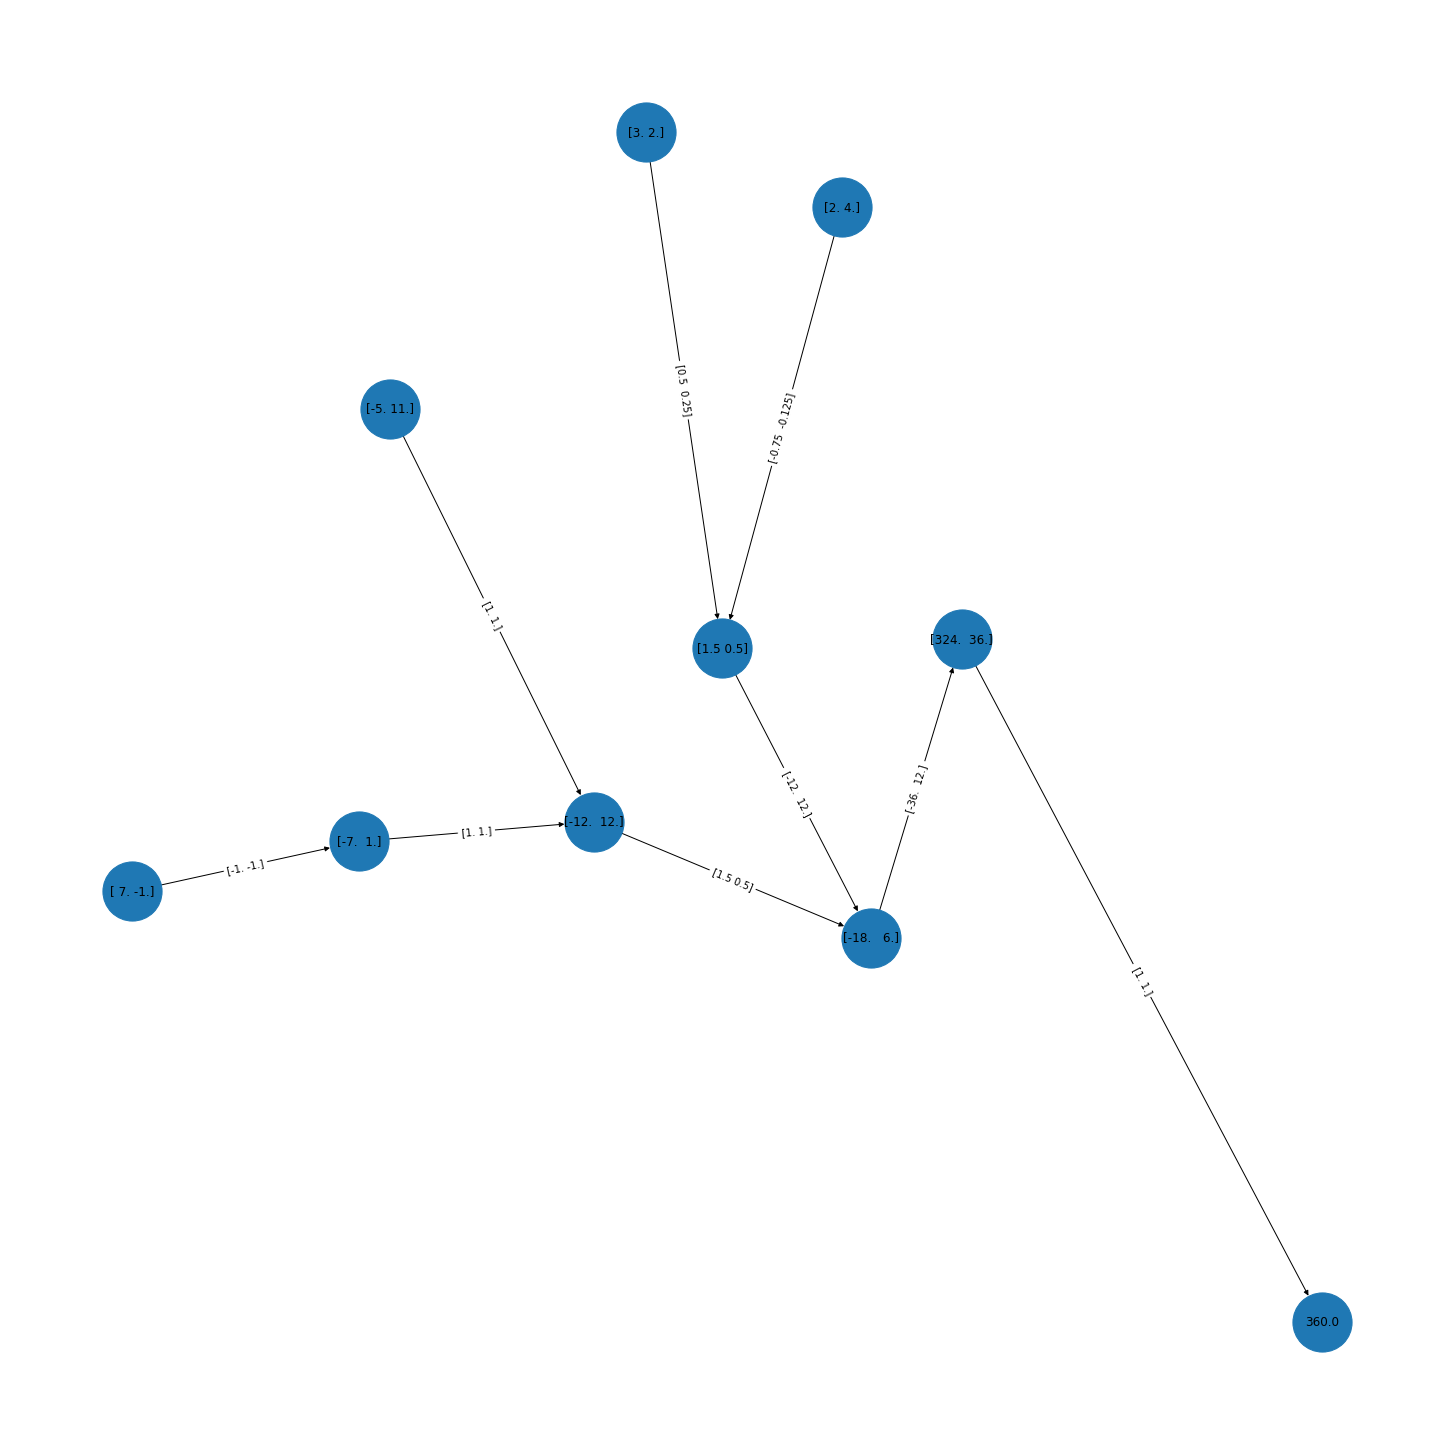

In [8]:
GRAPH.draw()

### Now we perform training the neural network on Iris dataset

In [9]:
# Loading iris dataset
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html

# Load standard sklearn libraries to
# 1. load iris dataset
# 2. perform train test split
# 3. perform preprocessing of the dataset

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

np.random.seed(0)

data = load_iris()

X = data['data']
y = data['target']

# Splitting the train and test dataset
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)

# Transform the train and test dataset
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [10]:
# Defining the sigmoid non-linearity
def sigmoid(x):
    return Tensor(1.) / (Tensor(1.0) + x._exp())

# Defining the softmax function
def softmax(X):
    outputs = []
    total = Tensor(0.)
    
    for x in X:
        x_e = x._exp()
        outputs.append(x_e)
        total = total + x_e

    for i in range(len(outputs)):
        outputs[i] = outputs[i] / total
    
    return outputs

# Defining the cross entropy loss
def cross_entropy(target_cls, y_pred):
    l = len(y_pred)
    y = np.zeros(l)
    y[target_cls] = 1.0
    
    loss = Tensor(0.)
    for i in range(l):
        loss = loss - (Tensor(y[i]) * y_pred[i]._log())
    
    return loss.sum() / Tensor(l * 1.0)

In [11]:
# Defining the training step
def train(n, use_sigmoid=False):
    global GRAPH
    global weights
    lr = 0.3
    total_loss = 0.
    outputs = []
    for x, y in zip(X_train, y_train):
        del GRAPH
        GRAPH = ComputationalGraph()

        curr_weights = [0.] * n_labels
        for i in range(n_labels):
            curr_weights[i] = Tensor(weights[i].value)

        del weights
        weights = curr_weights

        x = Tensor(np.append(x, 1.0)) # One for bias
        # Calculate prediction for each of the class
        output = []
        for i in range(n_labels):
            nn_output = (weights[i] * x).sum() # Apply neural network weights
            if use_sigmoid:
                nn_output = sigmoid(nn_output) # Apply non-linearity
            output.append(nn_output)
        output = softmax(output)

        l = cross_entropy(y, output)
        l.backward()

        # Update all the weights
        for i in range(n_labels):
            weights[i] = weights[i] - lr * weights[i].grad

        temp = []
        for val in output:
            temp.append(val.value.item())
        predicted_label = np.argmax(temp)
        outputs.append(predicted_label)
        total_loss += l.value.item()
    print('Total training loss after epoch {} is {}'.format(n + 1, total_loss))
    
    return total_loss, outputs

# Defining the testing step
def test(use_sigmoid=False):
    global GRAPH
    global weights
    total_loss = 0.
    outputs = []
    for x, y in zip(X_test, y_test):
        del GRAPH
        GRAPH = ComputationalGraph()

        curr_weights = [0.] * n_labels
        for i in range(n_labels):
            curr_weights[i] = Tensor(weights[i].value)

        del weights
        weights = curr_weights

        x = Tensor(np.append(x, 1.0)) # One for bias
        # Calculate prediction for each of the class
        output = []
        for i in range(n_labels):
            nn_output = (weights[i] * x).sum() # Apply neural network weights
            if use_sigmoid:
                nn_output = sigmoid(nn_output) # Apply non-linearity
            output.append(nn_output)
        output = softmax(output)

        l = cross_entropy(y, output)

        temp = []
        for val in output:
            temp.append(val.value.item())
        predicted_label = np.argmax(temp)
        outputs.append(predicted_label)
        total_loss += l.value.item()

    print('Total test loss is {}'.format(total_loss))
    
    return total_loss, outputs

dim = 4
n_labels = 3
# initialize random weights of the neural networks (1 layered neural network)
weights = [Tensor(np.random.rand(dim + 1)) for i in range(n_labels)]

n_epochs = 4
train_losses = []
train_accuracies = []

for n in range(n_epochs):
    total_loss, outputs = train(n)
    accuracy = (np.array(outputs) == y_train).mean()
    print('For epoch #{}: Loss: {:.2f} and Accuracy: {:.2f}'.format(n + 1, total_loss, accuracy))
    
    train_losses.append(total_loss)
    train_accuracies.append(accuracy)

# Save weights obtained after the training of the neural network
print('\n', weights)
np.save('weights-1.npy', weights)

Total training loss after epoch 1 is 14.885157542537339
For epoch #1: Loss: 14.89 and Accuracy: 0.83
Total training loss after epoch 2 is 10.10630344260847
For epoch #2: Loss: 10.11 and Accuracy: 0.88
Total training loss after epoch 3 is 8.276379166548343
For epoch #3: Loss: 8.28 and Accuracy: 0.91
Total training loss after epoch 4 is 7.078212900846379
For epoch #4: Loss: 7.08 and Accuracy: 0.92

 [Tensor([-0.29499667  1.50241351 -0.74536568 -0.71466335 -0.15880504]), Tensor([ 1.12256823 -0.14813988  0.86647625  0.31317264  1.56822896]), Tensor([ 1.15886109  0.32739786  1.94147037  2.8356333  -0.53129154])]


In [12]:
test_loss, outputs = test()
accuracy = (np.array(outputs) == y_test).mean()
print('\n\nTest performance - Loss: {:.2f} and Accuracy: {:.2f}'.format(total_loss, accuracy))

Total test loss is 3.8913391789139244


Test performance - Loss: 7.08 and Accuracy: 0.96


### As can be seen above, the training accuracy came out to be **92%** and the test accuracy came out to be **96%**

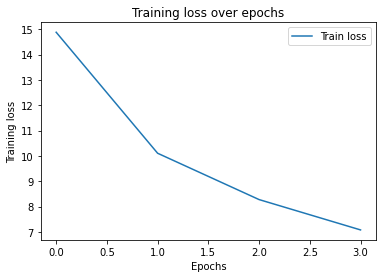

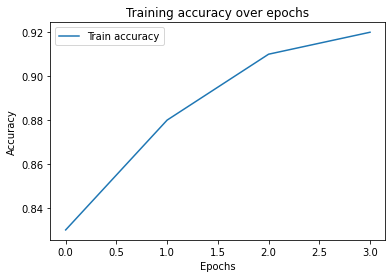

In [13]:
train_losses_df = pd.DataFrame({'Train loss': train_losses})

ax = sns.lineplot(data=train_losses_df).set(title='Training loss over epochs', xlabel='Epochs', ylabel='Training loss')
plt.show()

train_accuracy_df = pd.DataFrame({'Train accuracy': train_accuracies})
ax = sns.lineplot(data=train_accuracy_df).set(title='Training accuracy over epochs', xlabel='Epochs', ylabel='Accuracy')
plt.show()

### Below cell performs the neural network training with a sigmoid non-linearity

In [14]:
# Initialize random weights
weights = [Tensor(np.random.rand(dim + 1)) for i in range(n_labels)]

# Perform training step
n_epochs = 4
train_losses = []
train_accuracies = []

for n in range(n_epochs):
    total_loss, outputs = train(n, use_sigmoid=True)
    accuracy = (np.array(outputs) == y_train).mean()
    print('For epoch #{}: Loss: {:.2f} and Accuracy: {:.2f}'.format(n + 1, total_loss, accuracy))
    
    train_losses.append(total_loss)
    train_accuracies.append(accuracy)

print('\n', weights)
# save weights
np.save('weights-2.npy', weights)

# Perform testing step
test_loss, outputs = test(use_sigmoid=True)

accuracy = (np.array(outputs) == y_test).mean()
print('\n\nTest performance - Loss: {:.2f} and Accuracy: {:.2f}'.format(total_loss, accuracy))

Total training loss after epoch 1 is 34.10262260836045
For epoch #1: Loss: 34.10 and Accuracy: 0.61
Total training loss after epoch 2 is 30.189762483324913
For epoch #2: Loss: 30.19 and Accuracy: 0.80
Total training loss after epoch 3 is 27.06087277133282
For epoch #3: Loss: 27.06 and Accuracy: 0.85
Total training loss after epoch 4 is 26.01673376649028
For epoch #4: Loss: 26.02 and Accuracy: 0.86

 [Tensor([ 0.54378416 -0.60288354  1.54049773  1.43762369  0.98998864]), Tensor([ 0.48932357  1.63784794 -0.1969751   0.3320249   0.18945824]), Tensor([-0.58948726  0.18538416 -0.57738886 -1.19787009  0.4873165 ])]
Total test loss is 13.02773328324157


Test performance - Loss: 26.02 and Accuracy: 0.84


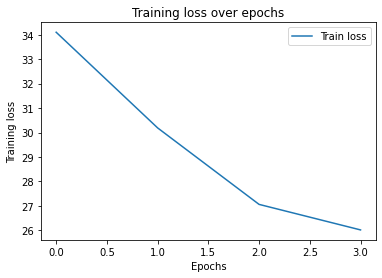

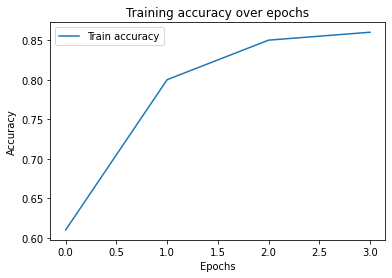

In [15]:
train_losses_df = pd.DataFrame({'Train loss': train_losses})

ax = sns.lineplot(data=train_losses_df).set(title='Training loss over epochs', xlabel='Epochs', ylabel='Training loss')
plt.show()

train_accuracy_df = pd.DataFrame({'Train accuracy': train_accuracies})
ax = sns.lineplot(data=train_accuracy_df).set(title='Training accuracy over epochs', xlabel='Epochs', ylabel='Accuracy')
plt.show()